In [3]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
dataset='/content/drive/MyDrive/Flower_dataset/archive.zip'


In [6]:
# Unzip the dataset
import zipfile

with zipfile.ZipFile(dataset, "r") as zip_ref:
    zip_ref.extractall()

In [7]:
data_dir = '/content/flowers'

print(os.listdir(data_dir))

['tulip', 'sunflower', 'dandelion', 'rose', 'daisy']


In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define data transforms (you can customize these as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image values
])



In [9]:
random_seed = 42
torch.manual_seed(random_seed);

In [10]:

# Define the full dataset
dataset = datasets.ImageFolder(root="/content/flowers", transform=transform)

# Define the sizes for training, validation, and test sets
total_size = len(dataset)     #4317
train_size = 2500
val_size = 1000
test_size = 817

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])



In [11]:

# Create data loaders for each set
batch_size =30  # You can adjust this as needed
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)






In [12]:
# Assuming you have already defined the data loaders
# train_loader, val_loader, test_loader

# Define a dictionary to map class indices to class names
class_idx_to_name = dataset.classes

# Iterate through the training loader to print image labels
for batch_idx, (images, labels) in enumerate(train_loader):
    for i in range(len(labels)):
        label_idx = labels[i].item()
        label_name = class_idx_to_name[label_idx]
        print(f"Image {i} has label: {label_name}")
        break
    break


Image 0 has label: daisy


In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
from torchvision.utils import make_grid
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))      # permute>>> chane the colorchannel position to the last one.
    break



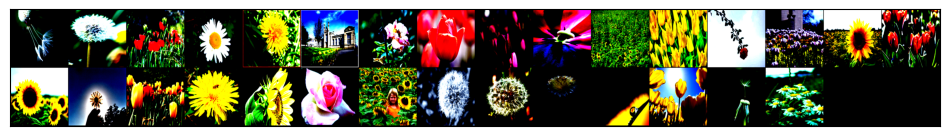

In [14]:
show_batch(train_loader)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [17]:
for images , labels in train_loader:
  print('images.shape:', images.shape)
  out = simple_model(images)
  print('out.shape:', out.shape)
  break

images.shape: torch.Size([30, 3, 224, 224])
out.shape: torch.Size([30, 8, 112, 112])


In [18]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class ImageClassifictionBase(nn.Module):
  def training_step(self , batch):
    images, labels = batch
    out = self(images)                        # Generate predictions
    loss = F.cross_entropy(out, labels)       # Calculate loss
    return loss

  def validation_step(self , batch):
    images, labels = batch
    out = self(images)                        # Generate predictions
    loss = F.cross_entropy(out, labels)       # calaculate loss
    acc = accuracy(out , labels)              # calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}


  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        # combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f},  val_loss: {:.4f}, val_acc: {:.4}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

  def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [20]:
class Cifar10CnnModel(ImageClassifictionBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3 , 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #output: 64*112*112

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output: 128*56*56

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(2, 2), #output: 256 * 28 * 28

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(2, 2), #output: 256 * 14 * 14

          nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(2, 2), #output: 1024 * 7 * 7

        nn.Flatten(),
        nn.Linear(1024*7*7, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 5))

  def forward(self, xb):
      return self.network(xb)

In [21]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [22]:
for images, labels in train_loader:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:',out[0])
  break

images.shape: torch.Size([30, 3, 224, 224])
out.shape: torch.Size([30, 5])
out[0]: tensor([ 0.0352,  0.0336,  0.0207, -0.0205, -0.0195],
       grad_fn=<SelectBackward0>)


In [23]:
def get_default_device():
  """ Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device=device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model , device);

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
  """Evaluate the model's performance on the validation set"""
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  """Train the model using gradient descent"""
  history=[]
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [27]:
model = to_device(Cifar10CnnModel(), device)

In [28]:
evaluate(model, val_loader)

{'val_loss': 1.607697606086731, 'val_acc': 0.25}

In [29]:
num_epochs = 1
opt_func = torch.optim.Adam  # used a momentum technique which make faster the training process
lr = 0.0001

In [30]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 1.5940,  val_loss: 1.4868, val_acc: 0.2833


In [ ]:
import torch

# Your existing code for training (assuming 'model' is your PyTorch model)
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

# Save the trained model
torch.save(model.state_dict(), 'saved_model')


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy VS. No. of epochs');

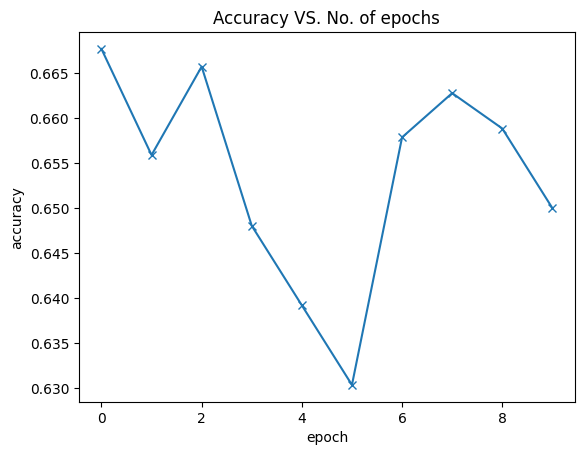

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses= [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss VS. No. of epochs');

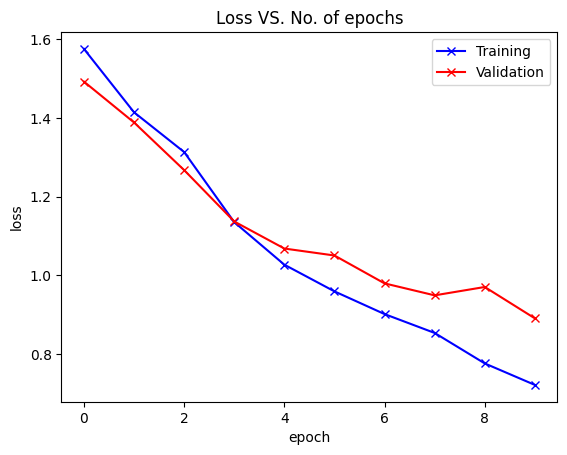

In [ ]:
plot_losses(history)

In [ ]:
def predict_image(img, model):
    #Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _,  preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label:  tulip , predicted: tulip


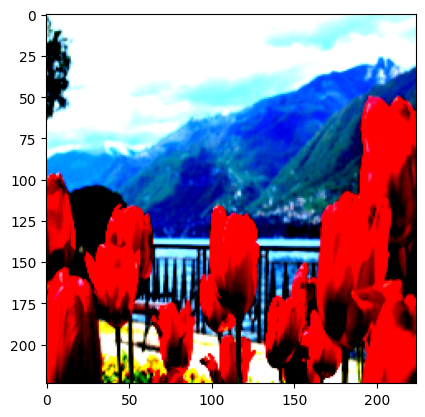

In [ ]:
img, label = test_set[0]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', predicted:', predict_image(img, model))

Label:  dandelion , predicted: dandelion


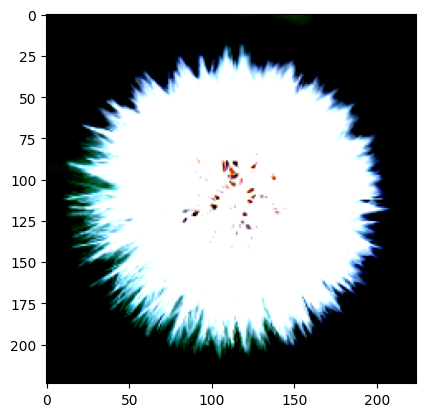

In [ ]:
img, label = test_set[4]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', predicted:', predict_image(img, model))

Label:  dandelion , predicted: dandelion


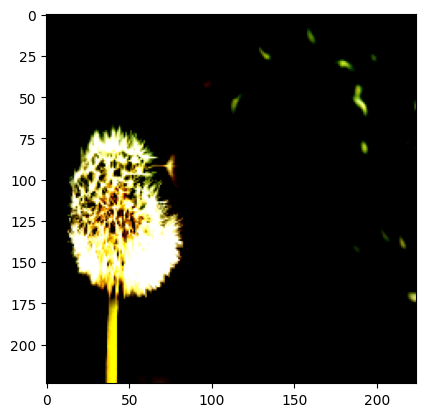

In [ ]:
img, label = test_set[200]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', predicted:', predict_image(img, model))

Label:  dandelion , predicted: dandelion


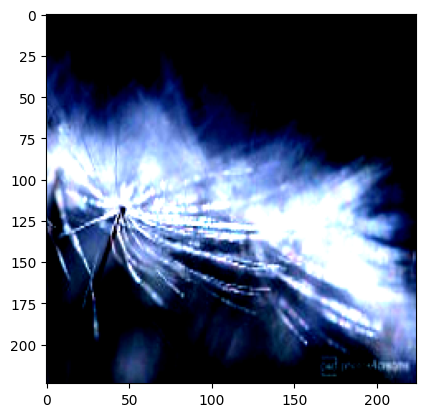

In [ ]:
img, label = test_set[500]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', predicted:', predict_image(img, model))

Label:  sunflower , predicted: sunflower


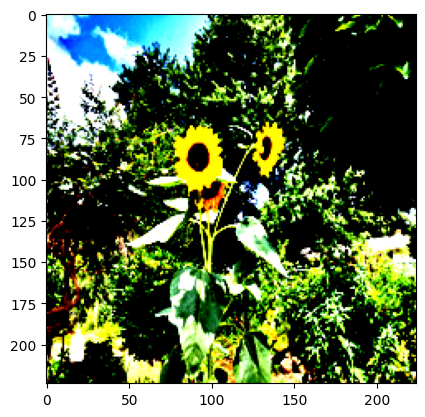

In [ ]:
img, label = test_set[600]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', predicted:', predict_image(img, model))